In [351]:
from IPython import display as disp
import torch
import torchaudio
from scipy.signal import wiener, convolve
from scipy.special import sinc
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib
import soundfile
import torchvision
from torchvision import transforms, utils
import librosa
import soundfile as sf
import pyloudnorm as pyln
import torchmetrics

In [59]:
torch.cuda.is_available()

True

In [60]:
!wget https://spandh.dcs.shef.ac.uk/avlombard/data/lombardgrid_audio.zip

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [61]:
!unzip -q lombardgrid_audio.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [205]:
def snr_mixer(clean, noise, snr):
    amp_noise = np.linalg.norm(clean) / 10**(snr / 20)

    noise_norm = (noise / np.linalg.norm(noise)) * amp_noise

    mix = clean + noise_norm

    return mix

def vad_merge(w, top_db):
    intervals = librosa.effects.split(w, top_db=top_db)
    temp = list()
    for s, e in intervals:
        temp.append(w[s:e])
    return np.concatenate(temp, axis=None)

def cut_audios(s1, s2, sec, sr):
    cut_len = sr * sec
    len1 = len(s1)
    len2 = len(s2)

    s1_cut = []
    s2_cut = []

    segment = 0
    while (segment + 1) * cut_len < len1 and (segment + 1) * cut_len < len2:
        s1_cut.append(s1[segment * cut_len:(segment + 1) * cut_len])
        s2_cut.append(s2[segment * cut_len:(segment + 1) * cut_len])

        segment += 1

    return s1_cut, s2_cut

def fix_length(s1, s2, min_or_max='max'):
    if min_or_max == 'min':
        utt_len = min(s1.shape[1], s2.shape[1])
        s1 = s1[:utt_len]
        s2 = s2[:utt_len]
    else:
        utt_len = max(s1.shape[1], s2.shape[1])
        s1 = torch.cat((s1, torch.zeros(utt_len - s1.shape[1]).to(s1.device)[None, :]), dim=1)
        s2 = torch.cat((s2, torch.zeros(utt_len - s2.shape[1]).to(s1.device)[None, :]), dim=1)
    return s1, s2

In [326]:
def snr(est, target):
    return 20 * np.log10(torch.norm(target) / (torch.norm(target - est) + 1e-6) + 1e-6)

def si_sdr(est, target):
    alpha = (target * est).sum() / torch.norm(target)**2
    return 20 * torch.log10(torch.norm(alpha * target) / (torch.norm(alpha * target - est) + 1e-6) + 1e-6)

In [206]:
import os
wav1, sr1 = torchaudio.load("../audio/" + os.listdir("../audio")[2221], format="wav")
disp.display(disp.Audio(wav1.numpy(), rate=sr1))

import os
wav2, sr2 = torchaudio.load("../audio/" + os.listdir("../audio")[1000], format="wav")
disp.display(disp.Audio(wav2.numpy(), rate=sr2))

disp.display(disp.Audio(wav2.numpy() + wav1.numpy()[:, :37920], rate=sr2))


In [336]:
print(wav1.shape)
wav1, wav2 = fix_length(wav1, wav2)
print(wav1.shape)

wav_mixed = snr_mixer(wav1, wav2, snr=10)
disp.display(disp.Audio(wav_mixed, rate=sr2))

torch.Size([1, 44160])
torch.Size([1, 44160])


In [337]:
si_sdr(wav_mixed, wav1)

tensor(9.9903)

In [338]:
meter = pyln.Meter(sr1)
loudness = meter.integrated_loudness(wav2.numpy()[0, :])
wav2_normalized = pyln.normalize.loudness(wav2.numpy()[0, :], input_loudness=loudness, target_loudness=-20)
disp.display(disp.Audio(wav2_normalized, rate=sr2))

In [339]:
wav0 = vad_merge(wav1.numpy()[0, :], 5)
disp.display(disp.Audio(wav0, rate=sr2))

In [380]:
from torch.utils.data import Dataset, DataLoader

class GRIDDataset(Dataset):
    """
    GRID dataset

    https://spandh.dcs.shef.ac.uk/avlombard
    """

    def __init__(self, root_dir, format='wav', transform=None):
        """
        Arguments:
            root_dir (string): A path, root directory.
        """
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.format = format
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        speaker = float(self.files[idx].split("_")[0][1:])
        signal, sr = torchaudio.load(
            self.root_dir + "/" + self.files[idx],
            format=self.format
        )

        sample = {'speaker' : speaker, 'signal': signal, 'sr' : sr}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [381]:
def collate_grid(batch):
  # L = max([x['signal'].shape[1] for x in batch])
  # L = 40000
  # T = 100
  # batch_ = []
  # for x in batch:
  #   if x['spectrogram'].shape[2] >= T:
  #     batch_.append(x)
  # batch = batch_
  # for x in batch:
  #   if x['signal'].shape[1] < L:
  #     x['signal'] = torch.cat((x['signal'], torch.zeros(1, L - x['signal'].shape[1])), dim=1)
  #   else:
  #     x['signal'] = x['signal'][:, :L]
  #   # x['spectrogram'] = torch.flatten(x['spectrogram'][:, :, :T], start_dim=1)
  #   x['spectrogram'] = x['spectrogram'][:, :, :T]
  return {
      'signal': torch.stack([x['signal'] for x in batch]),
      'spectrogram': torch.stack([x['spectrogram'] for x in batch]),
      'speaker': torch.tensor([x['speaker'] for x in batch]),
      'sr': torch.tensor([x['sr'] for x in batch])
}

In [382]:
def melForward(f):
    return 2595*torch.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

def get_spectrogram(signal):
    nFFT = 1024
    windowSize = nFFT
    hopSize = 256
    window = torch.hann_window(windowSize).to(signal.device)

    spectrum1 = torch.stft(
        signal,
        n_fft=nFFT,
        hop_length=hopSize,
        win_length=windowSize,
        window=window,
        center=False,
        onesided=True,
        return_complex=True,
    )

    spectrogram = melForward(spectrum1.abs().pow(2) + 1e-8)
    return spectrogram

class Spectrogrammify(object):
    """Convert waveform to spectrogram."""

    def __call__(self, sample):
        signal = sample['signal']
        spectrogram = get_spectrogram(signal)

        res = {}
        for k, v in sample.items():
            res[k] = v
        
        res['spectrogram'] = spectrogram

        return res
    
class NormalizeSpectrogram(object):
    """Convert waveform to spectrogram."""

    def __call__(self, sample):
        spectrogram = sample['spectrogram']

        normalize = transforms.Normalize(0, 1)

        res = {}
        for k, v in sample.items():
            res[k] = v

        return res

In [411]:
class MixedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset) * (len(self.dataset) - 1) // 2

    def __getitem__(self, idx):
        N = len(self.dataset)
        i, j = idx // N, idx % N

        sample_i, sample_j = self.dataset[i], self.dataset[j]
        assert sample_i['sr'] == sample_j['sr']

        signal1, signal2 = sample_i['signal'], sample_j['signal']
        
        signal1, signal2 = fix_length(signal1, signal2)

        L = 27000
        signal1 = signal1[:, :L]
        signal2 = signal2[:, :L]

        signal = snr_mixer(signal1, signal2, snr=10)

        sample = {
            'speaker1' : sample_i['speaker'],
            'speaker2' : sample_j['speaker'],
            'signal1' : signal1,
            'signal2' : signal2,
            'signal' : signal,
            'sr' : sample_i['sr'],
        }

        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample

In [412]:
ROOT_DIR = '../audio/'
dataset = GRIDDataset(
  root_dir=ROOT_DIR, 
  transform=transforms.Compose([Spectrogrammify(), NormalizeSpectrogram()])
)
dataset = MixedDataset(
   dataset,
   transform=transforms.Compose([Spectrogrammify(), NormalizeSpectrogram()])
)
dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])
dataloader_train = DataLoader(dataset_train, batch_size=4,
                        shuffle=True,) # num_workers=2)
dataloader_val = DataLoader(dataset_val, batch_size=4,
                        shuffle=True,) # num_workers=2,)
dataloader_test = DataLoader(dataset_test, batch_size=4,
                        shuffle=True,) # num_workers=2,)

print(dataset[1])

# if __name__ == '__main__':
for i_batch, sample in enumerate(dataloader_train):
    print(i_batch, sample['signal'].shape, sample['sr'][0])
    disp.display(disp.Audio(sample['signal'][0, 0, :].numpy(), rate=sample['sr'][0].item()))

    # observe 4th batch and stop.
    if i_batch == 3:
      break

{'speaker1': 10.0, 'speaker2': 10.0, 'signal1': tensor([[ 0.0003,  0.0003,  0.0003,  ..., -0.0199, -0.0183, -0.0176]]), 'signal2': tensor([[0.0007, 0.0008, 0.0008,  ..., 0.0206, 0.0234, 0.0247]]), 'signal': tensor([[ 0.0004,  0.0004,  0.0005,  ..., -0.0161, -0.0141, -0.0132]]), 'sr': 16000, 'spectrogram': tensor([[[0.0017, 0.0373, 0.0153,  ..., 0.2523, 0.0779, 0.0265],
         [0.0232, 0.0519, 0.0606,  ..., 0.1085, 0.0193, 0.0083],
         [0.0153, 0.0152, 0.0189,  ..., 0.0082, 0.0039, 0.0032],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])}
0 torch.Size([4, 1, 27000]) tensor(16000)


1 torch.Size([4, 1, 27000]) tensor(16000)


2 torch.Size([4, 1, 27000]) tensor(16000)


3 torch.Size([4, 1, 27000]) tensor(16000)


In [413]:
dataset[100]['spectrogram'].shape

torch.Size([1, 513, 102])

In [414]:
dataset[100]['spectrogram'].shape[1] * dataset[100]['spectrogram'].shape[2]

52326

In [415]:
4096 * 57

233472

In [416]:
from torch import nn
from torch.nn import functional as F

speakers = 55

class FFN(nn.Module):
    def __init__(self, input_size):
        super(FFN, self).__init__()

        # N = torch.prod(input_size)

        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding="same"),
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding="same"),
            # nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.2),
            nn.ReLU(),

            nn.Linear(in_features=input_size[2], out_features=input_size[2]),

            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3,3), padding="same"),
            # nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(3,3), padding="same"),
            nn.ReLU(),

            # nn.Flatten(),
            # nn.Linear(1536, 1536),
            # nn.ReLU(),
            # nn.Linear(1536, output_size),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.seq(x)
        return out # F.softmax(out, dim=-1)

In [417]:
model = FFN(input_size=dataset[100]['spectrogram'].shape)
model(dataset[1]['spectrogram'][None, ...]).shape

torch.Size([1, 1, 513, 102])

In [418]:
import wandb

def get_labels(sample, target, device):
    return torch.stack([get_spectrogram(sample[target][i, ...].to(device)) for i in range(sample[target].shape[0])]).to(device)

def train_epoch(model, dataloader_train, criterion, optimizer, device):
    losses = []
    accuracies = []
    for sample in dataloader_train:
        x_batch = sample['spectrogram'].to(device)

        y_batch = get_labels(sample, 'signal1', device)

        output = model(x_batch)

        acc = torchmetrics.audio.SignalNoiseRatio().to(device)(output, y_batch)

        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
        accuracies.append(acc)

    losses = torch.Tensor(losses)
    accuracies = torch.Tensor(accuracies)

    return (losses.sum() / losses.shape[0]).item(), (accuracies.sum() / accuracies.shape[0]).item()

def train(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, n_epochs, device):
    wandb.init()
    model.train()
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        loss, acc = train_epoch(model, dataloader_train, criterion, optimizer, device)
        print(f"Train loss: {loss}, acc: {acc}")
        wandb.log({"train_loss" : loss, "train_acc" : acc})

        val_loss, val_acc = test(model, dataloader_val, criterion, device)
        print(f"Val loss: {val_loss}, acc: {val_acc}")
        wandb.log({"val_loss" : val_loss, "val_acc" : val_acc})

        scheduler.step()
        wandb.log({"learning rate" : scheduler.get_last_lr()[0]})
        
    wandb.finish()


def test(model, dataloader_test, criterion, device):
    model.eval()
    losses = []
    accuracies = []
    for sample in dataloader_test:
        x_batch = sample['spectrogram'].to(device)
        y_batch = get_labels(sample, 'signal1', device)

        with torch.no_grad():
            output = model(x_batch)

            acc = torchmetrics.audio.SignalNoiseRatio().to(device)(output, y_batch)

            loss = criterion(output, y_batch)

            losses.append(loss)
            accuracies.append(acc)
        
    losses = torch.Tensor(losses)
    accuracies = torch.Tensor(accuracies)

    return (losses.sum() / losses.shape[0]).item(), (accuracies.sum() / accuracies.shape[0]).item()

In [419]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [420]:
SZ = 513 * 100
SZ

51300

In [ ]:
model = FFN(input_size=dataset[100]['spectrogram'].shape)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
criterion = nn.MSELoss(reduction='sum')

train(model, dataloader_train, dataloader_val, criterion, optimizer, scheduler, n_epochs=20, device=device)

Epoch 0 of 20


In [31]:
test(model, dataloader_test, criterion, device)

(0.9412932395935059, 0.9456790685653687)

In [299]:
sample = next(iter(dataloader))
sample

{'signal': tensor([[[ 4.3029e-04,  4.2468e-04,  4.4227e-04,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]],
 
         [[ 4.1795e-04,  4.0573e-04,  4.3124e-04,  ...,  6.1929e-05,
            2.6107e-05, -3.9279e-05]],
 
         [[ 1.7786e-04,  1.7470e-04,  1.5652e-04,  ...,  3.6299e-04,
           -2.6345e-05,  1.3542e-04]]]),
 'spectrogram': tensor([[[[8.5910e-01, 6.4362e+00, 8.0519e+00,  ..., 1.1132e+00,
            1.2357e+00, 1.3716e-01],
           [8.5010e-01, 2.6667e+00, 3.8610e+00,  ..., 3.8404e-01,
            5.6587e-01, 3.4334e-01],
           [8.5980e-02, 9.1622e-02, 2.0433e-01,  ..., 2.3376e-02,
            2.9422e-02, 3.6945e-02],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]]],
 
 
     

In [304]:
output = model(sample['spectrogram'].to(device))
pred = torch.argmax(output[:, :], 1)
pred + 1

tensor([ 7, 45, 29], device='cuda:0')

In [308]:
sample['signal'].shape

torch.Size([3, 1, 40000])

In [319]:
# wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[2000], format="wav")
idx = 2
disp.display(disp.Audio(sample['signal'][idx, 0, :].numpy(), rate=int(sample['sr'][idx])))

In [292]:
import gc
torch.cuda.empty_cache()
gc.collect()

4521

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [138]:
import os
wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[100], format="wav")
disp.display(disp.Audio(wav.numpy(), rate=sr))

In [139]:
nFFT = 1024
windowSize = nFFT
hopSize = 256
window = torch.hann_window(windowSize)

In [140]:
def melForward(f):
    return 2595*np.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

torch.Size([1, 513, 50])


C:\Users\maxro\AppData\Local\Temp\ipykernel_5112\3846563539.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


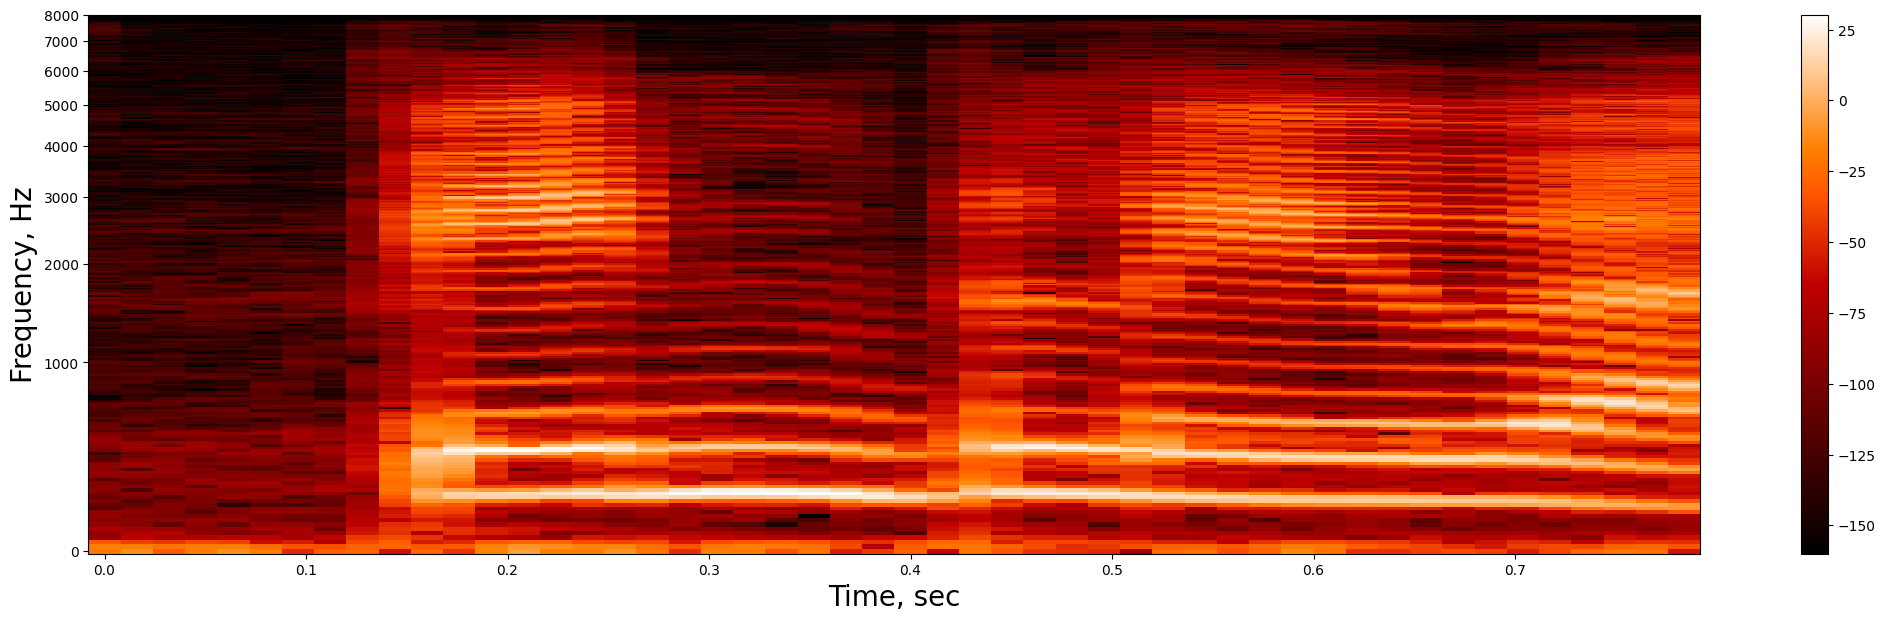

In [230]:
spectrum1 = torch.stft(
    wav,
    n_fft=nFFT,
    hop_length=hopSize,
    win_length=windowSize,
    window=window,
    center=False,
    onesided=True,
    return_complex=True,
)

# spectrogram = spectrum1.norm(dim=-1).pow(2)

# spectrum1[:, :67] = 0
# spectrum1[:, :100] = 0

spectrogram = spectrum1.abs().pow(2)

spectrogram = spectrogram[:, :, :50]
print(spectrogram.shape)

f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spectrogram.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(0,nFFT/2+0.00001)/(nFFT)*sr
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spectrogram.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

In [220]:
spectrogram.shape

torch.Size([1, 513, 100])

In [113]:
torch.flatten(spectrogram, start_dim=1).shape

torch.Size([1, 68742])

In [ ]:
wav_revived = torch.istft(spectrum1,
                          n_fft=nFFT,
                          hop_length=hopSize,
                          win_length=windowSize,
                          window=window)
wav_revived.shape

torch.Size([1, 43264])

In [ ]:
disp.display(disp.Audio(wav_revived.numpy(), rate=sr))

In [ ]:
torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1).shape

torch.Size([1, 44320])

In [ ]:
torch.norm(torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1)) / wav.shape[1]

tensor(6.7353e-05)